2. Customer Engagement (Jun An)
○ What factors are most strongly correlated with customer engagement in
marketing campaigns?
○ Objective: Analyze historical marketing campaign data to identify the main
drivers of customer interaction and response.
○ Expected Outcome: Propose key metrics for tracking customer engagement
over time.

In [1]:
import pandas as pd 
import numpy as np 
import math
import os

os.chdir("..")
path = os.getcwd()
print(path)
data_folder_name = "Data DSA3101"
data_folder = os.path.join(path, data_folder_name)
os.chdir(data_folder)
# Load dataframes customer_engagement and campaigns and merge them on campaign_id
customers = pd.read_csv("customers.csv")
customers = customers[customers['age'] >= 21]
customers = customers[customers['income'] >= 0]
#print(customers.head())
customer_engagement = pd.read_csv("customer_engagement.csv")
campaigns = pd.read_csv("campaigns.csv")
churn_data = pd.read_csv("churn.csv")

main_df = pd.merge(customer_engagement, customers, on="customer_id", how="inner")
print(main_df.head())
main_df = pd.merge(main_df, campaigns, on="campaign_id", how="inner")
main_df = pd.merge(main_df, churn_data, on="customer_id", how="inner")


print(main_df.head())


/Users/junan/School/DSA3101/DSA3101-Project
   engagement_id  customer_id  campaign_id channel sent delivered opened  \
0              1         3110            1   Email  Yes       Yes     No   
1              2         2468            1   Email  Yes       Yes     No   
2              3         7168            1   Email  Yes       Yes     No   
3              4         9616            1   Email  Yes       Yes     No   
4              5         7365            1   Email  Yes       Yes     No   

  clicked      engagement_date engagement_time  ...    region  income  \
0      No  2022-03-26 14:34:53        14:34:53  ...  Suburban    2456   
1      No  2022-03-29 06:49:52        06:49:52  ...  Suburban    3406   
2      No  2022-04-02 13:34:07        13:34:07  ...     Urban    3989   
3      No  2022-03-26 11:50:42        11:50:42  ...  Suburban    5755   
4     Yes  2022-04-05 14:36:54        14:36:54  ...     Urban    3650   

                   created_at credit_card personal_loan mort

In [2]:
from sklearn.preprocessing import LabelEncoder
# Ensure categorical values are converted to binary (Yes -> 1, No -> 0)
main_df['clicked'] = main_df['clicked'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['opened'] = main_df['opened'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['delivered'] = main_df['delivered'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['conversion_status'] = main_df['conversion_status'].apply(lambda x: 1 if x == 'Yes' else 0)
main_df['churn'] = main_df['churn_status'].apply(lambda x: 1 if x == 'Yes' else 0)
# Encode Channel
le = LabelEncoder()
main_df['channel_encoded'] = le.fit_transform(main_df['channel'])

# Ensure date column is in datetime format
main_df['engagement_date'] = pd.to_datetime(main_df['engagement_date'])

# Extract hour and day of week
main_df['engagement_hour'] = main_df['engagement_date'].dt.hour  # 0-23
main_df['engagement_day'] = main_df['engagement_date'].dt.weekday  # Monday=0, Sunday=6

# Group by campaign_id
campaign_metrics = main_df.groupby('campaign_id').agg(
    total_delivered=('delivered', 'sum'),
    total_clicked=('clicked', 'sum'),
    total_opened=('opened', 'sum'),
    total_converted=('conversion_status', 'sum'),
    channel = ('channel', 'first'),
    total_churned=('churn', 'sum'),
    day = ('engagement_day', 'mean'),
    hour = ('engagement_hour', 'mean')
).reset_index()

# Compute engagement metrics
campaign_metrics['CTR%'] = (campaign_metrics['total_clicked'] / campaign_metrics['total_delivered']) * 100
campaign_metrics['Open Rate%'] = (campaign_metrics['total_opened'] / campaign_metrics['total_delivered']) * 100
campaign_metrics['Conversion Rate%'] = (campaign_metrics['total_converted'] / campaign_metrics['total_delivered']) * 100
campaign_metrics['Churn Rate%'] = (campaign_metrics['total_churned'] / campaign_metrics['total_delivered']) * 100

# Fill NaN values with 0
campaign_metrics.fillna(0, inplace=True)

print(campaign_metrics)


    campaign_id  total_delivered  total_clicked  total_opened  \
0             1              433             32            95   
1             2              645             80           235   
2             3              890             48           212   
3             4              543             49           140   
4             5              719             62           225   
5             6              539             50           147   
6             7              458             33            82   
7             8              917             97           198   
8             9              764             61           140   
9            10              639             75           228   
10           11              205             21            47   
11           12              466             25           103   
12           13              656             56           207   
13           14              303             20            70   
14           15          

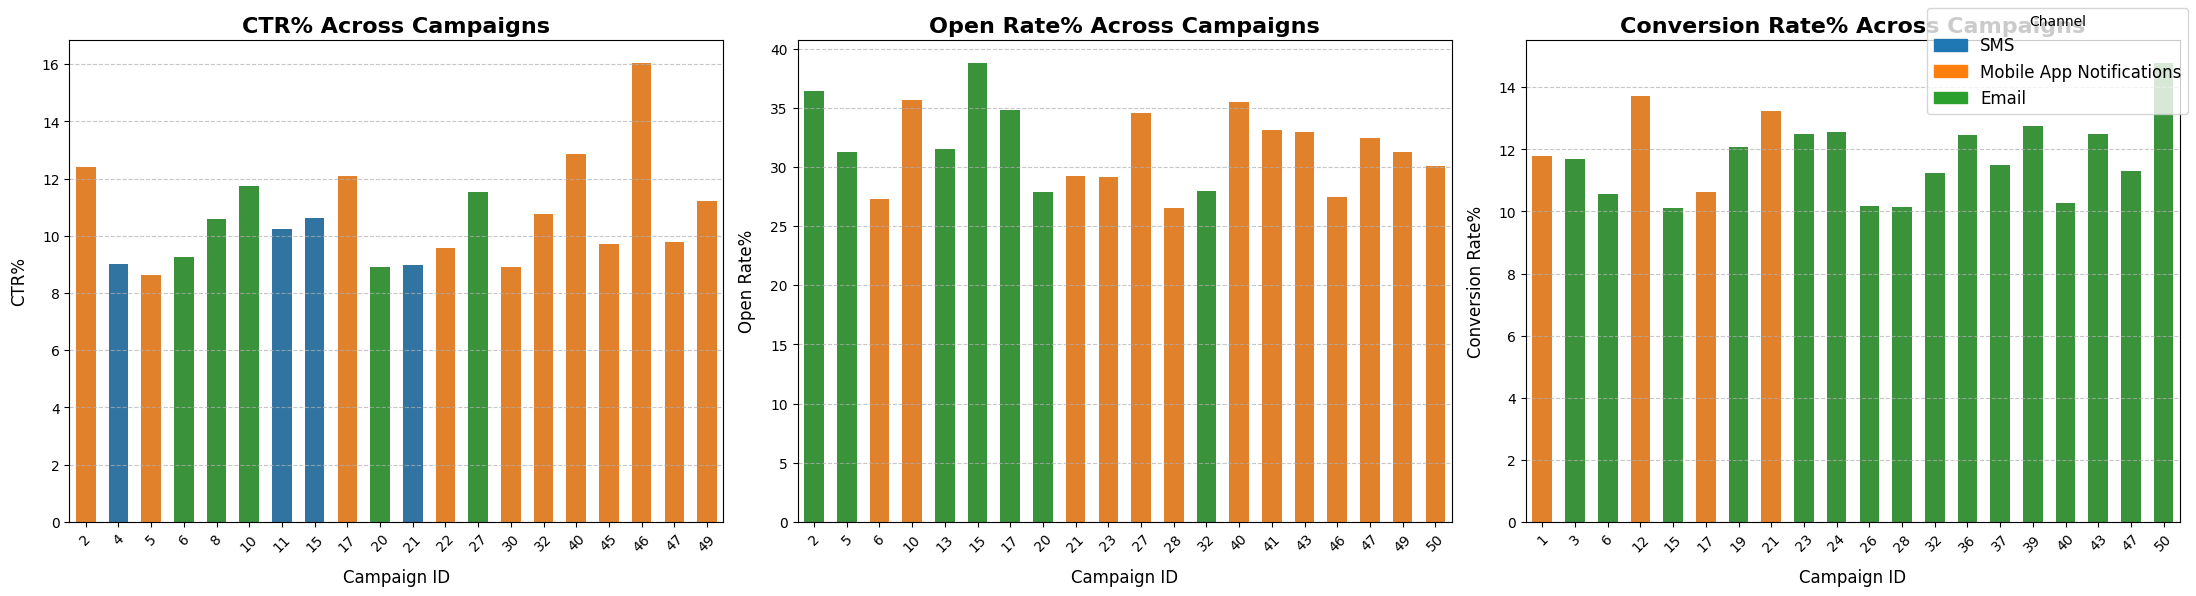

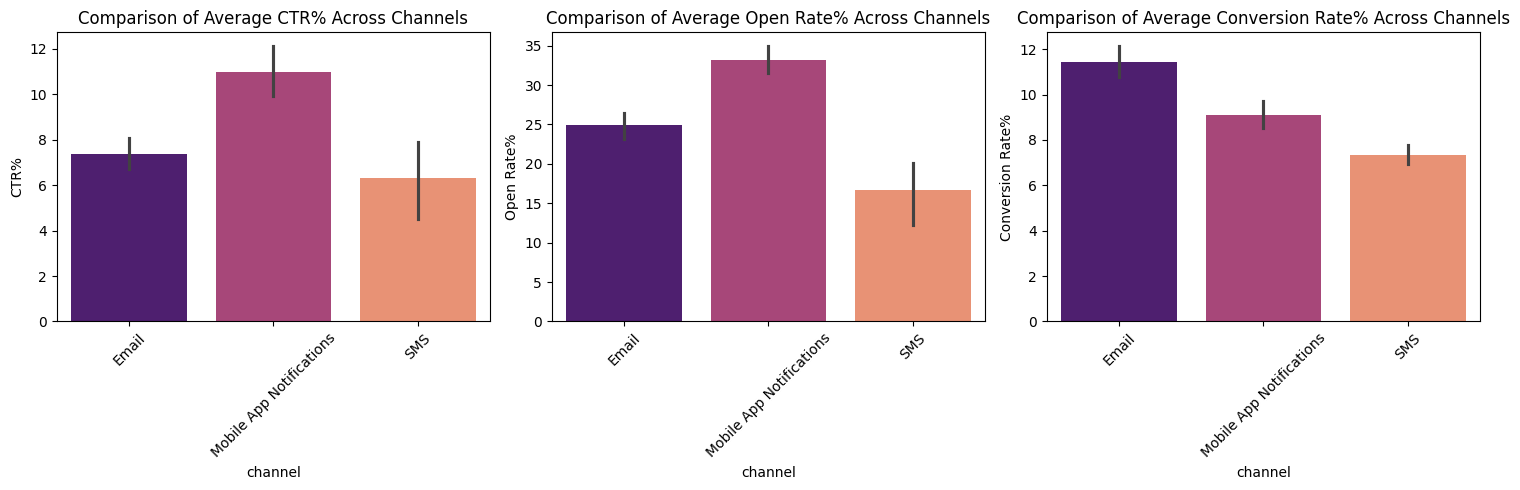

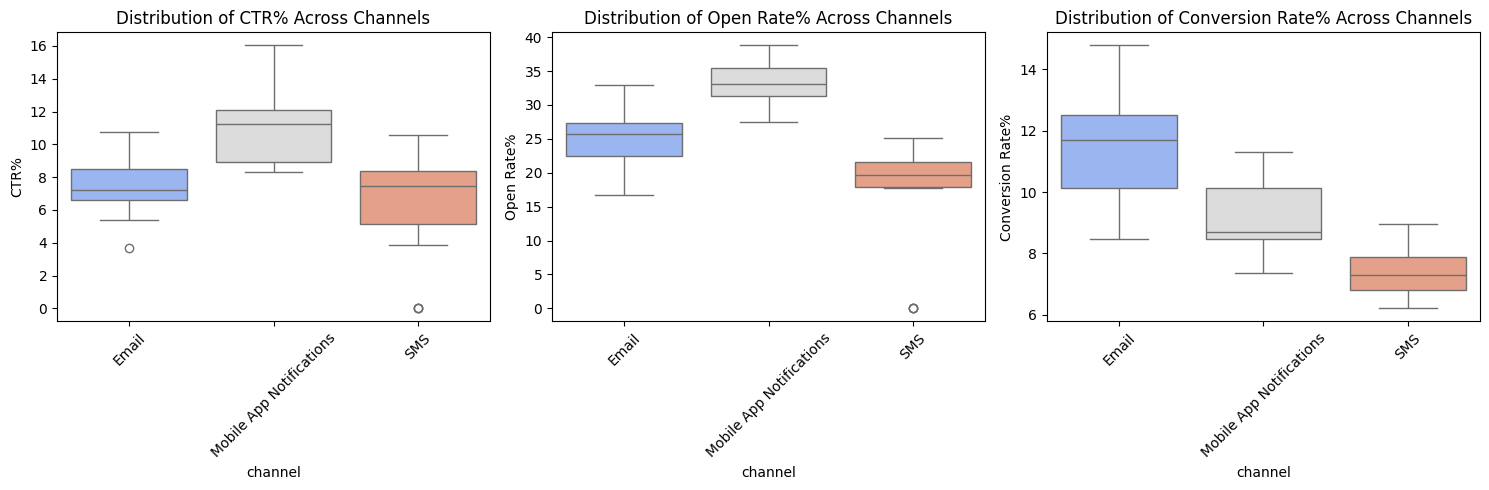

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# Compute correlation matrix
campaign_metrics = pd.get_dummies(campaign_metrics, columns=['channel'], drop_first= True)
# Identify the most used channel per campaign
campaign_metrics['channel'] = campaign_metrics[['channel_SMS', 'channel_Mobile App Notifications', 'channel_Email']].idxmax(axis=1)
campaign_metrics['channel'] = campaign_metrics['channel'].str.replace('channel_', '')

# Define color mapping for each channel
channel_colors = {
    "SMS": "#1f77b4",  # Blue
    "Mobile App Notifications": "#ff7f0e",  # Orange
    "Email": "#2ca02c"  # Green
}

# Replace infinite values with NaN and drop NaN rows *before* sorting
campaign_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)
campaign_metrics.dropna(subset=['CTR%', 'Open Rate%', 'Conversion Rate%'], how='all', inplace=True)

# Define figure size
fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=False)

# Metrics and titles
metrics = ['CTR%', 'Open Rate%', 'Conversion Rate%']
titles = ['CTR% Across Campaigns', 'Open Rate% Across Campaigns', 'Conversion Rate% Across Campaigns']

# Track valid plots
valid_axes = []

# Loop through each metric and create sorted bar plots
for i, metric in enumerate(metrics):
    # Filter out NaN values before sorting
    metric_data = campaign_metrics.dropna(subset=[metric])
    
    if metric_data.empty:  # Skip if no valid data
        axes[i].set_visible(False)
        continue

    valid_axes.append(axes[i])  # Track valid axes
    
    # Sort in ascending order and pick top 20 campaigns
    sorted_campaigns = metric_data.sort_values(by=metric, ascending=True).tail(20)
    
    # Map colors based on the channel type
    colors = sorted_campaigns['channel'].map(channel_colors)
    
    sns.barplot(
        x=sorted_campaigns['campaign_id'], 
        y=sorted_campaigns[metric], 
        ax=axes[i], 
        palette=colors.tolist(),  # Assign colors dynamically
        width=0.6
    )
    
    axes[i].set_title(titles[i], fontsize=16, fontweight='bold')
    axes[i].set_xlabel('Campaign ID', fontsize=12, labelpad=10)
    axes[i].set_ylabel(metric, fontsize=12, labelpad=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Remove unused axes
if len(valid_axes) < len(axes):
    for i in range(len(valid_axes), len(axes)):
        fig.delaxes(axes[i])

# Add a legend for channel colors
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in channel_colors.values()]
labels = list(channel_colors.keys())
fig.legend(handles, labels, title="Channel", loc='upper right', fontsize=12)

# Adjust layout and display plot
plt.tight_layout()
plt.show()


engagement_metrics = ['CTR%', 'Open Rate%', 'Conversion Rate%']

### 🎯 2. Compare Engagement Between Channels (Using One-Hot Encoded Data)
# Compute average engagement per channel
#channel_metrics = campaign_metrics.copy()
plt.figure(figsize=(15, 5))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(data=campaign_metrics, x="channel", y=metric, palette="magma")
    plt.xticks(rotation=45)
    plt.title(f"Comparison of Average {metric} Across Channels")

plt.tight_layout()
plt.show()

# Box plot for distribution of engagement across channels
plt.figure(figsize=(15, 5))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=campaign_metrics, x="channel", y=metric, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {metric} Across Channels")

plt.tight_layout()
plt.show()



                                  Churn Rate%      CTR%  Open Rate%  \
Churn Rate%                          1.000000  0.298592    0.227062   
CTR%                                 0.298592  1.000000    0.792001   
Open Rate%                           0.227062  0.792001    1.000000   
Conversion Rate%                    -0.034520 -0.193040    0.220573   
channel_Email                       -0.201177 -0.164495    0.050881   
channel_Mobile App Notifications     0.378708  0.578514    0.621953   
channel_SMS                         -0.155112 -0.038233   -0.278637   
day                                 -0.252495  0.138019    0.149118   
hour                                 0.172624  0.048902    0.098902   

                                  Conversion Rate%  channel_Email  \
Churn Rate%                              -0.034520      -0.201177   
CTR%                                     -0.193040      -0.164495   
Open Rate%                                0.220573       0.050881   
Conversion Ra

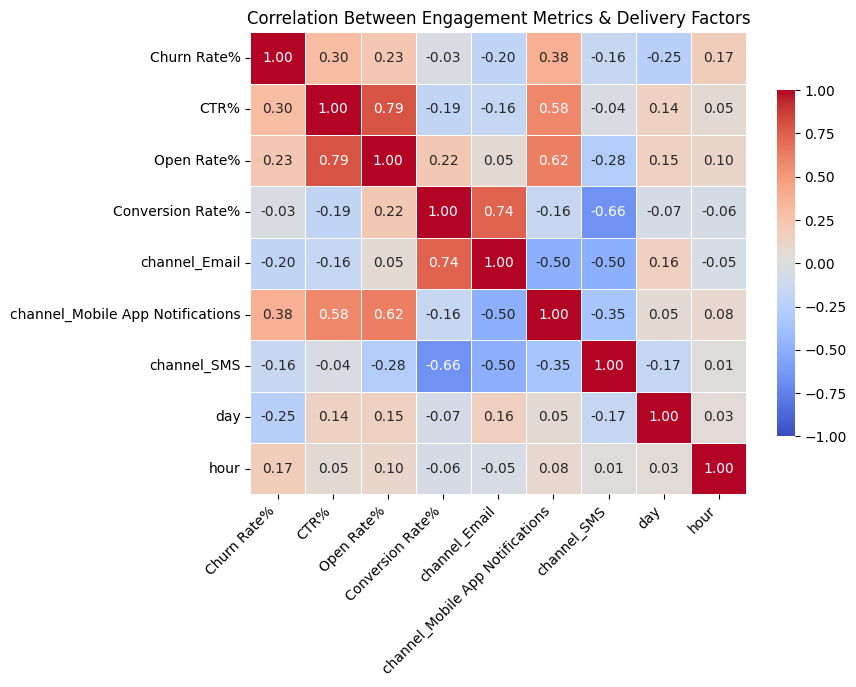

In [4]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = campaign_metrics[['Churn Rate%','CTR%', 'Open Rate%', 'Conversion Rate%', 'channel_Email', 'channel_Mobile App Notifications', 'channel_SMS', 'day', 'hour']].corr()

# Print correlation table
print(corr_matrix)

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.75}, 
    vmin=-1, 
    vmax=1
)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Correlation Between Engagement Metrics & Delivery Factors")
plt.show()